In [33]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
df=pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [36]:
df.columns=['Sales']

<Axes: xlabel='DATE'>

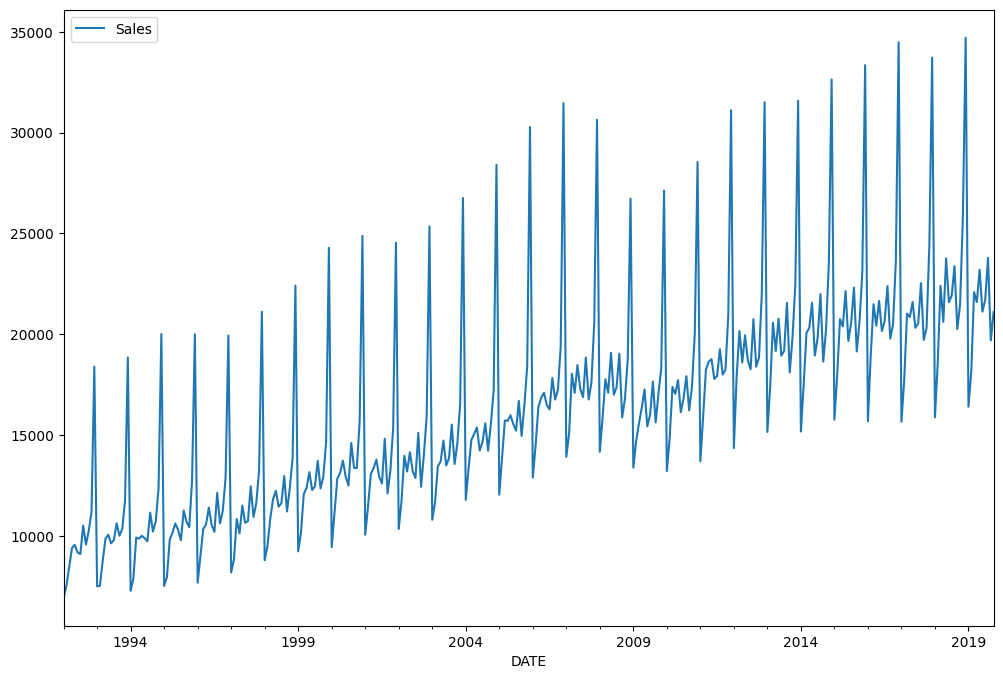

In [37]:
df.plot(figsize=(12,8))

In [38]:
test_size=18 #In months
test_ind=len(df)-test_size

In [39]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
len(train),len(test)

(316, 18)

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [41]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
# Let's redefine to get 12 months back and then predict the next month out from 18 months
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [44]:
# What does the first batch look like?
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [46]:
# We're only using one feature in our time series
n_features = 1

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [49]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [50]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\arind\AppData\Local\Temp\ipykernel_15164\1350552164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 6s 8ms/step - loss: 0.0230 - val_loss: 0.0073
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0023
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 5.7562e-04
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0063 - val_loss: 8.6155e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 4.0447e-04
Epoch 6/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0012


<Axes: >

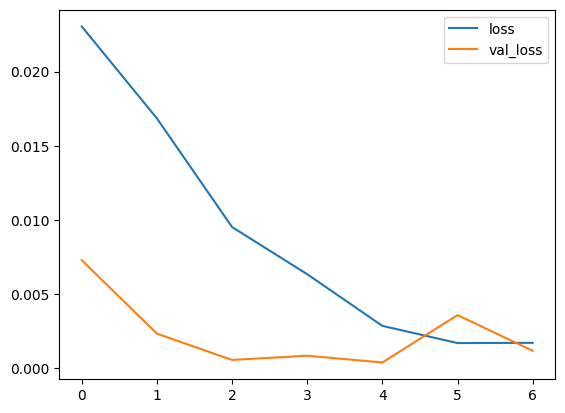

In [51]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [52]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 46ms/step


In [53]:
true_predictions = scaler.inverse_transform(test_predictions)

In [54]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\arind\AppData\Local\Temp\ipykernel_15164\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='DATE'>

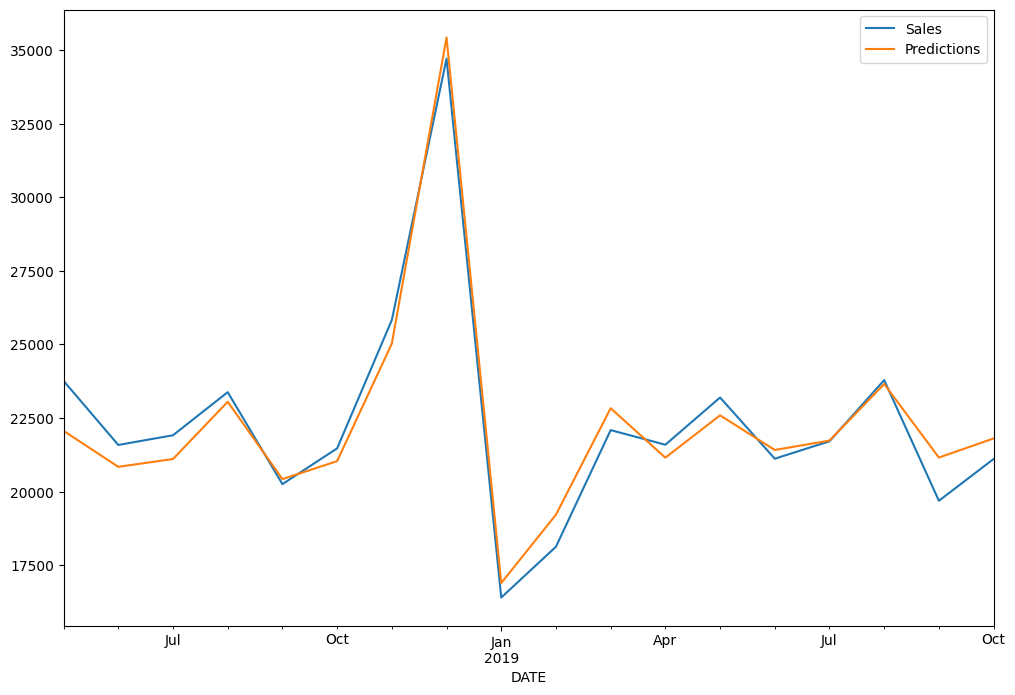

In [55]:
test.plot(figsize=(12,8))

# Retrain and forecasting

In [56]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [57]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [58]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

C:\Users\arind\AppData\Local\Temp\ipykernel_15164\853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


Epoch 1/8
322/322 [==============================] - 5s 7ms/step - loss: 0.0240
Epoch 2/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0181
Epoch 3/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0113
Epoch 4/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0055
Epoch 5/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 6/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0025
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 8/8
322/322 [==============================] - 2s 8ms/step - loss: 0.0012


In [59]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 50ms/step


In [60]:
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<Axes: >

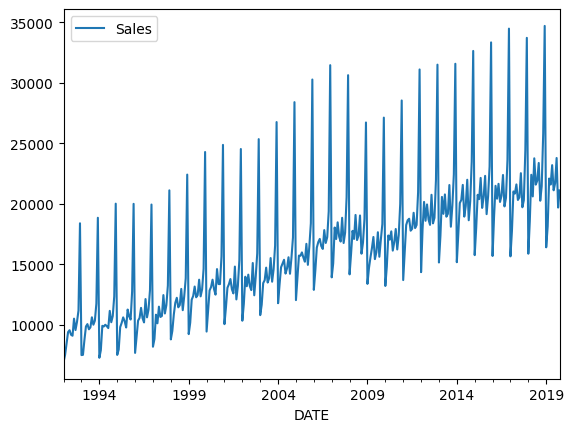

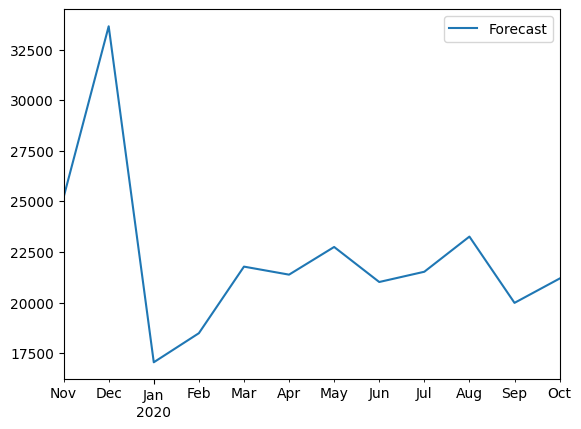

In [61]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

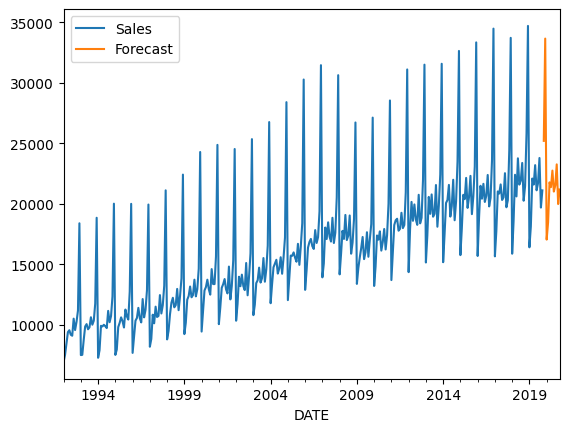

In [62]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

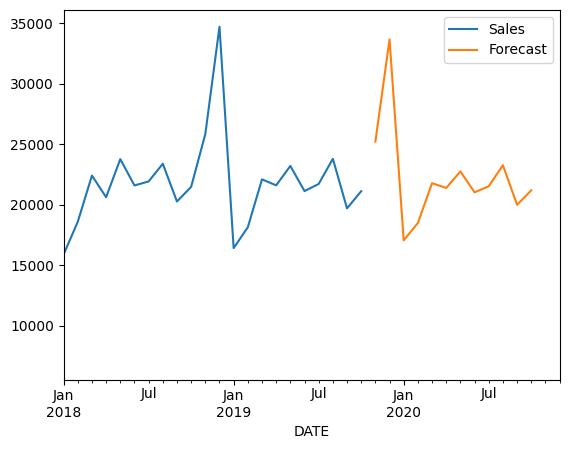

In [63]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')